In [1]:
CITY = 2304400
CITY_NAME = 'Fortaleza'
STATE = 'CE'
FILENAME_DATA = f'../../data/dengue_{CITY}_cluster.csv'
FILE_CHIK = f'../../data/chik_{CITY}_cluster.csv'

In [2]:
import sys
import pickle
sys.path.append('../..')
import numpy as np
import tensorflow as tf
import pandas as pd
from datetime import datetime
from pgbm_model import pgbm_pred
import matplotlib.pyplot as plt
from preprocessing import get_nn_data
from lstm import build_model, make_pred
from plots_lstm import plot_loss, plot_comp 
from sklearn.metrics import mean_squared_error as mse 

In [3]:
df_dengue = pd.read_csv(FILENAME_DATA, index_col = 'Unnamed: 0' )
df_dengue.index = pd.to_datetime(df_dengue.index)
df_dengue

,casos_2307650,casos_est_2307650,casos_est_min_2307650,casos_est_max_2307650,p_rt1_2307650,p_inc100k_2307650,temp_min_2307650,temp_max_2307650,umid_min_2307650,pressao_min_2307650,...,casos_2302008,casos_est_2302008,casos_est_min_2302008,casos_est_max_2302008,p_rt1_2302008,p_inc100k_2302008,temp_min_2302008,temp_max_2302008,umid_min_2302008,pressao_min_2302008
2010-01-03,2,2.0,2,2,0.000000,0.871619,24.319912,30.486346,60.977150,0.996031,...,0,0.0,0,0,0.000000,0.000000,22.640307,30.403224,54.970053,0.996096
2010-01-10,3,3.0,3,3,0.000000,1.307429,24.411634,30.839578,57.369000,0.996246,...,0,0.0,0,0,0.000000,0.000000,22.182997,29.993391,56.564824,0.996851
2010-01-17,6,6.0,6,6,0.000000,2.614858,24.750937,32.868508,48.148234,0.997115,...,0,0.0,0,0,0.000000,0.000000,22.574323,31.373539,51.559022,0.997896
2010-01-24,4,4.0,4,4,0.000000,1.743238,24.381592,32.757769,52.469240,0.995866,...,0,0.0,0,0,0.000000,0.000000,22.169896,31.661416,50.600249,0.996541
2010-01-31,5,5.0,5,5,0.000000,2.179048,24.674992,31.494088,57.549285,0.995062,...,1,1.0,1,1,0.000000,4.394059,22.813411,31.559658,51.487102,0.995551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-19,71,92.0,74,200,0.009153,40.094482,22.944916,27.709486,75.758353,0.997039,...,5,5.0,5,8,0.824846,21.970297,22.074554,28.264007,64.974941,0.997236
2023-03-26,48,72.0,52,193,0.000284,31.378292,22.866660,29.595206,65.729017,0.997306,...,5,6.0,5,12,0.854627,26.364355,21.513641,28.862170,61.803014,0.998119
2023-04-02,26,59.0,32,248,0.001542,25.712767,23.083509,28.595555,74.222116,0.997248,...,4,7.0,4,20,0.799951,30.758415,21.488054,29.833902,56.197920,0.997743
2023-04-09,25,60.0,29,311,0.088288,26.148577,22.753963,28.771785,73.798959,0.996171,...,19,29.0,20,72,0.999945,127.427720,22.208356,29.759373,59.601682,0.996064


## Neural network model 

Parameters of the models:

In [4]:
END_DATE_TRAIN = '2022-01-02' # assign the last day used to evaluate the dengue model 
END_DATE = '2023-01-01'

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
BATCH_SIZE = 1
EPOCHS = 400
HIDDEN = 8
FEAT = 126 # number of features
l1 = 1e-6
l2 = 1e-6

Let's train the model with the loss function == msle 

Compilation Time :  0.0034990310668945312
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 126)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             8640      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 4)                 36        
                   

2023-05-06 23:49:04.159642: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


132/132 [==============================] - 3s 7ms/step - loss: 0.0095 - accuracy: 0.2171 - mape: 150.6301 - mse: 0.0137 - val_loss: 0.0067 - val_accuracy: 0.1613 - val_mape: 81.0229 - val_mse: 0.0108
Epoch 2/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0047 - accuracy: 0.2705 - mape: 85.9883 - mse: 0.0070 - val_loss: 0.0044 - val_accuracy: 0.2258 - val_mape: 129.5067 - val_mse: 0.0067
Epoch 3/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0043 - accuracy: 0.2438 - mape: 87.1127 - mse: 0.0064 - val_loss: 0.0047 - val_accuracy: 0.2151 - val_mape: 90.6904 - val_mse: 0.0076
Epoch 4/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0035 - accuracy: 0.2743 - mape: 81.8512 - mse: 0.0051 - val_loss: 0.0045 - val_accuracy: 0.3978 - val_mape: 81.5624 - val_mse: 0.0072
Epoch 5/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0035 - accuracy: 0.2705 - mape: 82.1808 - mse: 0.0050 - val_loss: 0.0042 - val_accuracy: 

Epoch 40/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0020 - accuracy: 0.3752 - mape: 67.9498 - mse: 0.0029 - val_loss: 0.0027 - val_accuracy: 0.4086 - val_mape: 79.9439 - val_mse: 0.0041
Epoch 41/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0020 - accuracy: 0.4057 - mape: 65.8932 - mse: 0.0028 - val_loss: 0.0026 - val_accuracy: 0.3978 - val_mape: 52.2967 - val_mse: 0.0038
Epoch 42/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0021 - accuracy: 0.4019 - mape: 65.7490 - mse: 0.0031 - val_loss: 0.0032 - val_accuracy: 0.3763 - val_mape: 65.5268 - val_mse: 0.0056
Epoch 43/400
132/132 [==============================] - 1s 6ms/step - loss: 0.0019 - accuracy: 0.4019 - mape: 65.5007 - mse: 0.0027 - val_loss: 0.0025 - val_accuracy: 0.4516 - val_mape: 93.9414 - val_mse: 0.0037
Epoch 44/400
132/132 [==============================] - 1s 5ms/step - loss: 0.0019 - accuracy: 0.4324 - mape: 72.0938 - mse: 0.0024 - val_loss: 0.0027 -

Epoch 79/400
132/132 [==============================] - 1s 5ms/step - loss: 0.0017 - accuracy: 0.4248 - mape: 62.3715 - mse: 0.0024 - val_loss: 0.0022 - val_accuracy: 0.5054 - val_mape: 61.3517 - val_mse: 0.0033
Epoch 80/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0017 - accuracy: 0.4305 - mape: 67.2013 - mse: 0.0022 - val_loss: 0.0021 - val_accuracy: 0.5161 - val_mape: 62.8016 - val_mse: 0.0031
Epoch 81/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0018 - accuracy: 0.4019 - mape: 65.4721 - mse: 0.0026 - val_loss: 0.0025 - val_accuracy: 0.3656 - val_mape: 70.7289 - val_mse: 0.0040
Epoch 82/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0018 - accuracy: 0.4190 - mape: 70.2456 - mse: 0.0024 - val_loss: 0.0028 - val_accuracy: 0.4516 - val_mape: 86.4825 - val_mse: 0.0043
Epoch 83/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0016 - accuracy: 0.4381 - mape: 66.2385 - mse: 0.0021 - val_loss: 0.0029 -

132/132 [==============================] - 1s 4ms/step - loss: 0.0015 - accuracy: 0.4076 - mape: 63.2605 - mse: 0.0020 - val_loss: 0.0029 - val_accuracy: 0.4731 - val_mape: 64.2859 - val_mse: 0.0051
Epoch 118/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0017 - accuracy: 0.4114 - mape: 74.5041 - mse: 0.0021 - val_loss: 0.0019 - val_accuracy: 0.4839 - val_mape: 57.1840 - val_mse: 0.0028
Epoch 119/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0016 - accuracy: 0.4248 - mape: 70.0579 - mse: 0.0020 - val_loss: 0.0024 - val_accuracy: 0.4624 - val_mape: 66.6671 - val_mse: 0.0038
Epoch 120/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0015 - accuracy: 0.4286 - mape: 62.0157 - mse: 0.0021 - val_loss: 0.0020 - val_accuracy: 0.4839 - val_mape: 59.7733 - val_mse: 0.0027
Epoch 121/400
132/132 [==============================] - 1s 4ms/step - loss: 0.0015 - accuracy: 0.4057 - mape: 68.7510 - mse: 0.0019 - val_loss: 0.0031 - val_accu

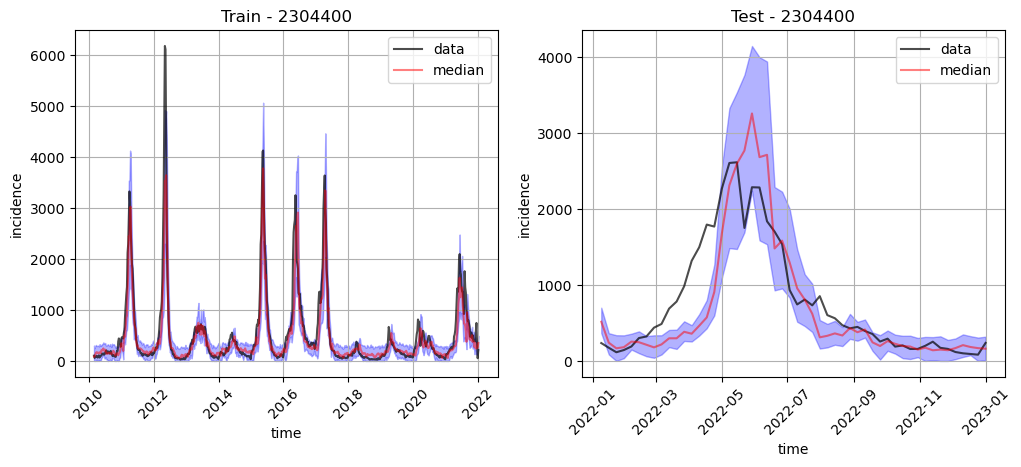

In [5]:
model = build_model(l1=l1, l2 = l2, hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=BATCH_SIZE, loss = 'msle', lr = 0.001)

m_msle_all, h_msle_all, m_train_all, m_val_all = make_pred(model, CITY, doenca = 'dengue', epochs = EPOCHS, end_train_date = END_DATE_TRAIN, 
                    ratio= None, end_date = END_DATE,
                     predict_n = PREDICT_N, look_back =  LOOK_BACK, label = 'msle_all',  filename = FILENAME_DATA)

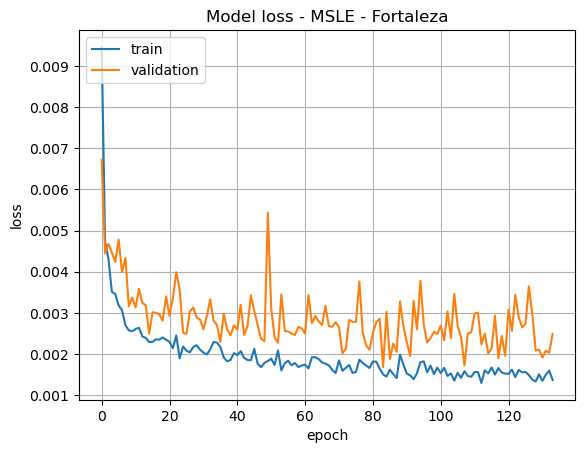

In [6]:
plot_loss(h_msle_all, title = 'Model loss - MSLE - Fortaleza')

PGBM model

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Estimator 0/100, Train metric: 706.0112
Estimator 1/100, Train metric: 645.2294
Estimator 2/100, Train metric: 590.1238
Estimator 3/100, Train metric: 539.9360
Estimator 4/100, Train metric: 494.6511
Estimator 5/100, Train metric: 453.6307
Estimator 6/100, Train metric: 416.5457
Estimator 7/100, Train metric: 382.9244
Estimator 8/100, Train metric: 352.1449
Estimator 9/100, Train metric: 323.8103
Estimator 10/100, Train metric: 298.0155
Estimator 11/100, Train metric: 274.9480
Estimator 12/100, Train metric: 253.4831
Estimator 13/100, Train metric: 234.4440
Estimator 14/100, Train metric: 216.7824
Estimator 15/100, Train metric: 200.9302
Estimator 16/100, Train metric: 186.5796
Estimator 17/100, Train metric: 173.4161
Estimator 18/100, Train metric: 161.3650
Estimator 19/100, Train metric: 150.3216
Estimator 20/100, Train metric: 140.5098
Estimator 21/100, Train metric: 131.3919
Estimator 22/100, Train metric: 123.0647
Estimator 23/100, Train metric: 115.6313
Estimator 24/100, Train me

Estimator 5/100, Train metric: 461.7075
Estimator 6/100, Train metric: 425.0691
Estimator 7/100, Train metric: 391.1652
Estimator 8/100, Train metric: 360.3106
Estimator 9/100, Train metric: 333.2858
Estimator 10/100, Train metric: 307.5465
Estimator 11/100, Train metric: 284.4169
Estimator 12/100, Train metric: 263.4081
Estimator 13/100, Train metric: 244.4158
Estimator 14/100, Train metric: 227.3927
Estimator 15/100, Train metric: 210.7909
Estimator 16/100, Train metric: 195.9117
Estimator 17/100, Train metric: 182.8999
Estimator 18/100, Train metric: 170.5712
Estimator 19/100, Train metric: 158.7211
Estimator 20/100, Train metric: 148.5298
Estimator 21/100, Train metric: 139.5523
Estimator 22/100, Train metric: 131.2988
Estimator 23/100, Train metric: 123.8674
Estimator 24/100, Train metric: 116.8440
Estimator 25/100, Train metric: 110.1354
Estimator 26/100, Train metric: 104.4207
Estimator 27/100, Train metric: 98.0601
Estimator 28/100, Train metric: 93.0119
Estimator 29/100, Train

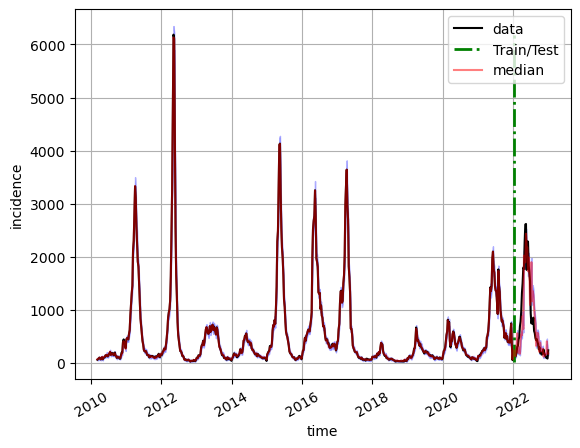

In [7]:
preds, preds25, preds975, X_train, targets = pgbm_pred(CITY, STATE, PREDICT_N, LOOK_BACK, doenca = 'dengue', ini_date = None, end_train_date = END_DATE_TRAIN, end_date = END_DATE,  filename = FILENAME_DATA)
   